In [53]:
import sys
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
sys.path.insert(0, '../code')
from fl_devices import Client, Server

In [45]:
torch.random.manual_seed(0)
c_pos = torch.randn(size=(4,2))*4
c_neg = torch.randn(size=(4,2))*4

In [126]:
client_data = [TensorDataset(torch.cat([torch.randn(size=(10,2))+c_pos[i%4],
                                        torch.randn(size=(10,2))+c_pos[(i+1)%4],
                                        torch.randn(size=(10,2))+c_neg[i%4],
                                       torch.randn(size=(10,2))+c_neg[(i+1)%4]]),
               torch.Tensor([0]*20+[1]*20).long())
               
               
               for i in range(100)]

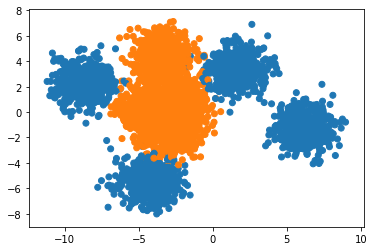

In [128]:
for dat in client_data:
    plt.scatter(*dat.tensors[0].numpy().T, c=["C0"]*20+["C1"]*20)
    
plt.show()

In [129]:
class model_fn(torch.nn.Module):
    def __init__(self):
        super(model_fn, self).__init__()
        self.fc1 = torch.nn.Linear(2, 10)
        self.fc2 = torch.nn.Linear(10, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [130]:
optimizer_fn = lambda x : torch.optim.Adam(x, lr=0.01, weight_decay=0.0)

In [131]:
clients = [Client(model_fn, optimizer_fn, subset, batch_size=10, layers="none", idnum=i)
           for i, subset in enumerate(client_data)]
server = Server(model_fn, client_data[0], layers="none")

In [135]:
for c_round in range(1, 11):

    participating_clients = server.select_clients(clients, 1.0)

    accs = []
    for i, client in enumerate(clients):
        client.synchronize_with_server(server)
        accs += [client.evaluate()["accuracy"]]
    print(np.mean(accs))

    for client in participating_clients:
        train_stats = client.compute_weight_update(1)  

    server.aggregate_weight_updates(clients)

0.97375
0.97375
0.975
0.97375
0.97625
0.97875
0.98125
0.98125
0.98
0.98125


In [155]:
n = 6

xx = np.linspace(-10,10,100)
yy = np.linspace(-10,10,100)
XY = torch.Tensor(np.stack(np.meshgrid(xx,yy), axis=2).reshape(-1,2))

Z = torch.softmax(clients[n].model(XY), dim=1)[:,1].detach().numpy().reshape(100,100)

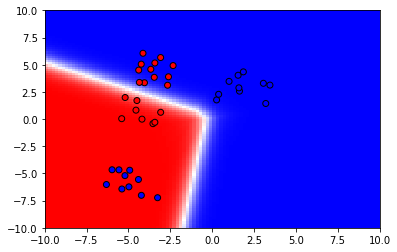

In [156]:
plt.imshow(Z, extent=[-10,10,-10,10], aspect="auto", cmap="bwr")
for dat in client_data[n:n+1]:
    plt.scatter(*dat.tensors[0].numpy().T, c=["blue"]*20+["red"]*20, ec="k")
plt.show()

In [90]:
plt.contour?